## Welcome to the basic neural network tutorial!
The following notebook is designed to walk through the process of building and training your first neural network using the standalone MaCh3 python utilities!

If you're writing scripts this is encapsulate in the objects in `MaCh3PythonUtils/config_reader` however this guide aims to break apart the process of writing the code for yourself!

The first step is to load in a MaCh3 MCMC fit as input file. This is done using the ChainHandler class!

In [1]:
# MaCh3Python Deps
from MaCh3PythonUtils.file_handling.chain_handler import ChainHandler
from MaCh3PythonUtils.machine_learning.ml_factory import MLFactory


# Other imports
from matplotlib import pyplot as plt
from pathlib import Path
import gdown

Using mps device

In [2]:
# Download file from google drive

file_url="https://drive.google.com/file/d/1iE6xFhn3BH_HnLUfQ7KFGy2wfeH52Rwf/view?usp=sharing"

# download the file
input_file = Path("../models/demo_chain.root")

if not input_file.exists():
    # download the file
    input_file.parent.mkdir(parents=True, exist_ok=True)
    gdown.download(file_url, str(input_file), quiet=False, fuzzy=True)


In [3]:
# Load in a file, for the purposes of this example we'll use a
# input_file = Path("../../../../T2K/AdaptiveTune/SummerProj/Adapt/NOvA/LongFit/Cut/mcmc_Adapt_NOvA_all_on.root")

# Set up file properties
chain_name = 'posteriors'
verbose=False

chain_handler = ChainHandler(str(input_file), chain_name, verbose=verbose)

Attempting to open ../models/demo_chain.root
Succesfully opened ../models/demo_chain.root:posteriors


Okay, now we've loaded in a file we need to do a bit of processing. This means we need to select the variables we care about and apply parameter cuts

In [4]:
# Firstly we set things we want to ignore, these are parameters we really don't care about/want to learn!
# chain_handler.ignore_plots(["LogL_systematic_xsec_cov", "Log", "LogL_systematic_osc_cov"])

chain_handler.ignore_plots(["xsec_20", "xsec_19"])
chain_handler.add_additional_plots(["xsec_0", "xsec_1", "xsec_2", "xsec_3", "xsec_4", "xsec_5", "xsec_6", "xsec_7", "xsec_8", "xsec_9", "xsec_10", "xsec_11", "xsec_12", "xsec_13",
                                    "xsec_14", "xsec_15", "xsec_16", "xsec_17", "xsec_18", "xsec_21", "xsec_22"])
# Now we add parameters we care about. Note this only need to be a substring of the full name
# chain_handler.add_additional_plots(["sin2th", "delm2", "delta", "xsec"])

# The fitting label is special, it's the thing we want to train our network to predict
fitting_label = "LogL_systematic_xsec_cov"
# We need to make sure the chain handler knows this exists, passing true means it is looking for some with that exact name
chain_handler.add_additional_plots(fitting_label, True)

# Finally we can do some cuts to get rid of things like burn-in
# chain_handler.add_new_cuts(["LogL<22.5", "step>10000", "delm2_23>0"])
chain_handler.add_new_cuts(["step>0", "LogL_systematic_xsec_cov<12345"])

# Last step is convert the chain into a pandas dataframe
chain_handler.convert_ttree_to_array()

Let's quickly use the chain handler to make a plot of the trace and posterior!

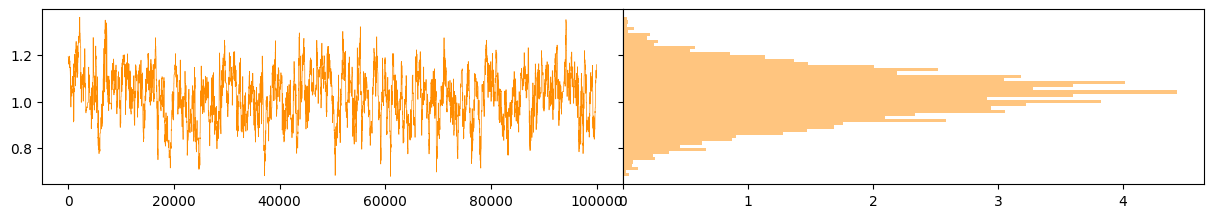

In [5]:
from MaCh3PythonUtils.file_handling.chain_diagnostics import ChainDiagnostics
plotter=ChainDiagnostics(chain_handler)

plotter("xsec_0")
plt.show()


## Machine learning
Okay now we've done some very basic file manipulation, it's time for some machine learning!
All algorithms use the same common `MLFactory` interface so let's go about configuring it!

In [6]:
# First step we need to initialise the factory

from pathlib import Path

model_output=Path("../models/my_model")
# Make sure the model output directory exists
model_output.parent.mkdir(parents=True, exist_ok=True)

# The factory produces ML models, we need to pass it the chain handler and the fitting label to get started
ml_factory = MLFactory(chain_handler, fitting_label, f"{model_output}.pdf")

Now we need to define a model, for this demonstration we'll make a very simple neural network!

In [7]:
# We now want the actual neural network properties
# Usually you set this using a YAML file (see configs for some examples) but we'll do this manually for now
build_settings = {
}

# Settings used when the model is fitting
fit_settings = {
    'num_epochs': 10000,
    'learning_rate': 0.01,
    'debug': True,
}

In [8]:
# Now we can make the model
layers = []
layers.append({"linear": {"in_features": chain_handler.ndim-1, "out_features": 16}})
layers.append({"leaky_relu": {}})
layers.append({"batch_norm": {'num_features': 16}})
layers.append({"linear": {"in_features": 16, "out_features": 32}})
layers.append({"leaky_relu": {}})
layers.append({"linear": {"in_features": 32, "out_features": 16}})
layers.append({"leaky_relu": {}})

layers.append({"linear": {"in_features": 16, "out_features": 1}})


ml_model = ml_factory.make_interface('Torch', 'sequential', Layers=layers, FitSettings=fit_settings, BuildSettings=build_settings)

# Let's use 20% of the data for testing
ml_model.set_training_test_set(0.5)

In [ ]:
# Now we need to train our network
ml_model.train_model()

Training model:   0%|          | 0/10000 [00:00<?, ?epoch/s]

Training Results!

Mean Absolute Error : 1.4847191753027202

Line of best fit : y=1.5123302551231461x + -2.071078294225607

Saving QQ to train_qq_plot.pdf

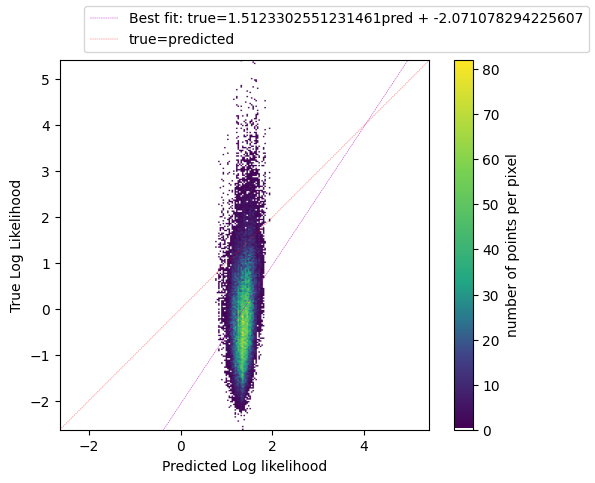

mean: -1.369461655091277, std dev: 0.9751198152328029

=====

Testing Results!

Mean Absolute Error : 1.4800941535508254

Line of best fit : y=1.4652746352543373x + -2.0105134458925833

Saving QQ to .pdf

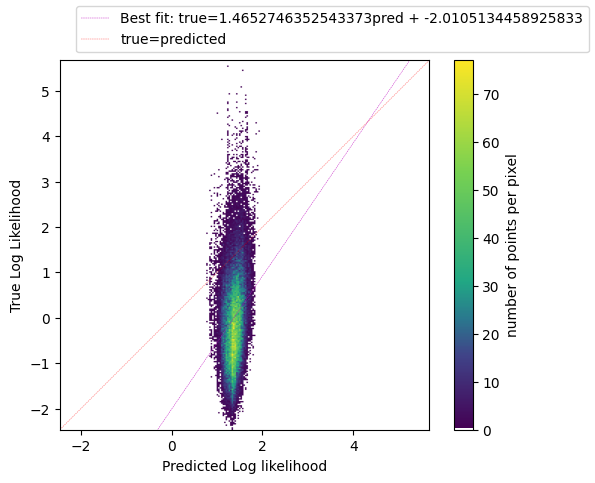

mean: -1.3733435717482056, std dev: 0.9634166089157359

=====

In [ ]:
# Now we need to test
ml_model.test_model()


Model Summary:

Model: Sequential(
  (0): Linear(in_features=21, out_features=16, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Linear(in_features=16, out_features=10, bias=True)
  (4): LeakyReLU(negative_slope=0.01)
  (5): Linear(in_features=10, out_features=1, bias=True)
)

Device: mps

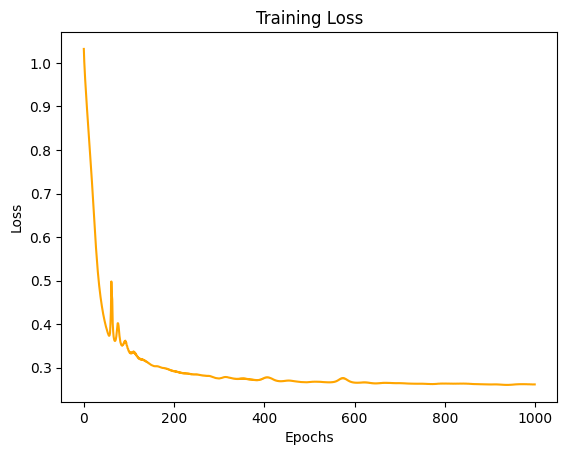

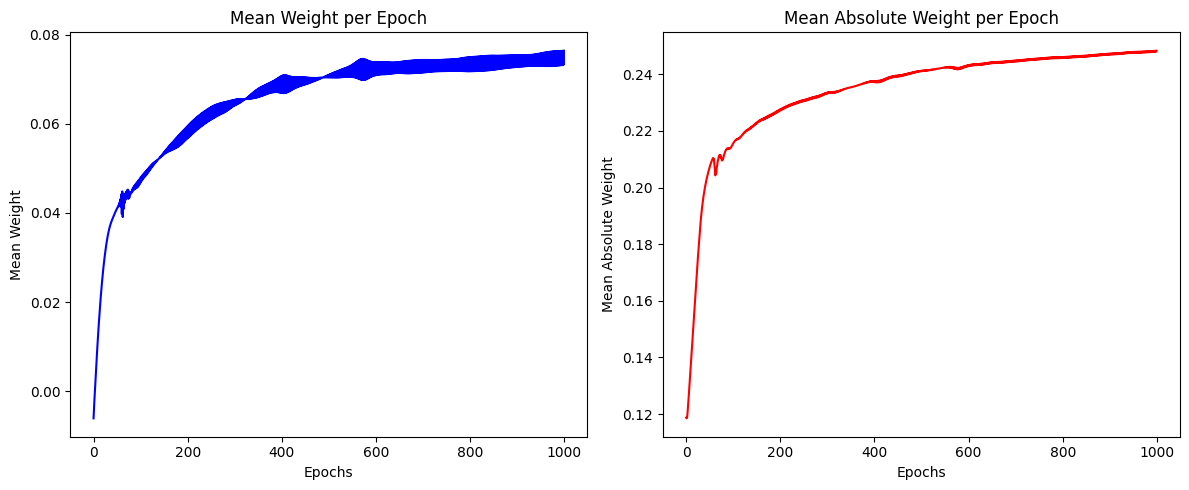

In [ ]:
# Now we can save it
ml_model.print_model_summary()